<a href="https://colab.research.google.com/github/pal-ette/iNotePal/blob/%236-%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94/models/%EA%B0%90%EC%84%B1%EB%8C%80%ED%99%94_KoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet-mkl==1.6.0 numpy==1.23.1

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.10.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch

In [ ]:
# KoBERT
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import tqdm

In [6]:
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [7]:
device = torch.device("cuda:0")

# Load Data

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Pal-ette/preprocessed_data/감성대화.csv')
df

,Unnamed: 0,감정_대분류,Emotion,사람문장
0,0,분노,1.0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...
1,1,분노,1.0,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....
2,2,분노,1.0,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,3,분노,1.0,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,4,분노,1.0,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...
...,...,...,...,...
58266,58266,당황,4.0,나랑 비슷한 시기에 결혼하는 친구는 시댁에서 집을 해줘서 너무 부러워. 우리는 대출...
58267,58267,당황,4.0,친구 한 명이 결혼해서 아이를 가졌는데 너무 행복해 보이더라. 기분이 좋지만은 않아...
58268,58268,당황,4.0,남들은 결혼 전에 일억을 모았다는데 난 뭐를 한 것인지 모르겠어. 자괴감만 드네.요...
58269,58269,당황,4.0,나보다 결혼을 먼저 한 친구가 부러워. 그 친구 남편은 직장도 내 남편보다 좋고 키...


In [9]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,감정_대분류,Emotion,사람문장
0,분노,1.0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...
1,분노,1.0,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....
2,분노,1.0,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...
3,분노,1.0,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...
4,분노,1.0,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...


### LabelEncoder

In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['Emotion'])

labels = LE.classes_
print(len(labels), labels)


5 [0. 1. 2. 3. 4.]


In [11]:
df['Emotion'].value_counts()

Emotion
4.0    17143
0.0    10433
1.0    10417
2.0    10150
3.0    10128
Name: count, dtype: int64

### Re-arrange Data

In [12]:
data_list = []
for q1, label in zip(df['사람문장'], df['Emotion']):
    data = []
    data.append(q1)
    data.append(str(int(label)))

    data_list.append(data)


data


['친구들 모두 결혼하고 나만 혼자 남아서 쓸쓸하네.맞아. 하지만 그렇다고 아무나하고 결혼할 수도 없잖아.', '4']

### Train / Test Split

In [32]:
from sklearn.model_selection import train_test_split
train_, test = train_test_split(data_list, test_size=0.2, random_state=0, shuffle=True)
train, valid = train_test_split(train_, test_size=0.25, random_state=0, shuffle=True)

print(len(train), len(valid), len(test))


34962 11654 11655



# KoBERTTokenizer

In [ ]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

### token length

In [33]:
train


[['당장 내일 보고서 제출일인데 큰일이야.급한데 동료가 자료를 안 넘겨주었어.', '1'],
 ['나는 요즘 불면증에 시달리고 있어.내가 다리가 불편해서 재택근무 삼아 블로그로 돈을 벌까 싶어 운영하고 있는데 요즘은 양심의 가책을 느껴.',
  '4'],
 ['매일 병상에 있던 아내가 외출이 허락되어서 같이 밖을 나갔는데 많이 좋아진 것 같아.아내가 웃는 모습을 오랜만에 봐서 좋았어.',
  '4'],
 ['너무 건강에 신경 쓰지 못해 후회돼.건강식품을 잘 챙겨 먹어야겠어.', '0'],
 ['운동을 제대로 배우려고 헬스장에 왔는데 아무도 나에게는 관심이 없어서 상처를 받았어.혼자 이용할 수 있는 러닝머신을 뛰고 있는데 다른 기구도 사용해보고 싶어.',
  '2'],
 ['건강식품을 샀는데 원액도 아니고 비싸서 환불 요구 했는데 거절당했어.내가 따로 먹은 것도 아니고 환불하는 게 당연한 거 아닌가?',
  '1'],
 ['노년이 되니 움직이기 불편하다.늙으니 남편과의 유대감도 상실해서 결혼 관계가 불만족이야.', '0'],
 ['학업 잘하는 애만 대접받는 이런 세상이 꼭 필요가 있을까.학습 못하는 나 같은 애는 세상에 필요가 없는 것 같아.', '3'],
 ['최근에 싸웠던 친구와 화해를 하게 되었어. 정말 좋은 친구였는데 화해해서 다행이야.예전부터 나는 힘들 때마다 친구에게 하소연했는데 친구에게는 버거웠나 봐. 이런 감정이 쌓이고 쌓였던 것 같아.',
  '4'],
 ['여자친구가 다른 남자와 키스하는 장면을 목격했어. 배신감 느껴.잘 모르겠어. 여자친구 얼굴을 다시는 보고 싶지 않아.', '1'],
 ['와이프랑 결혼식장에 가야 하는데 비가 올 것 같아서 가기 귀찮아.응. 와이프한테 혼자 가라고 하면 화내겠지?', '1'],
 ['나의 틱장애 때문에 아내가 집을 나가버렸어. 이젠 나 자신이 지긋지긋해.아내가 없으니 틱까지 있는 나는 혼자선 아무것도 할 수 없어.',
  '1'],
 ['아이들과 함께 주말을 집에서 보내니 편안하고 너무 좋아.요즘은 집안일을

*Todo*  
1.문장 1 문장 2 를 합쳐서 돌린다

In [34]:
class BERTDataset(Dataset):

    def __init__(self, dataset, q_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[q_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [35]:
tok = tokenizer.tokenize
max_len = 300

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False) # 294
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False) # 215

token_len_train = [d[1] for d in trainset]
token_len_test = [d[1] for d in testset]

In [36]:
print(min(token_len_train), max(token_len_train))
print(min(token_len_test), max(token_len_test))

13 148
13 118


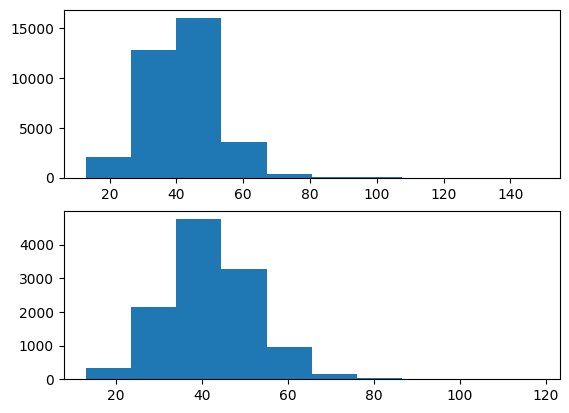

In [37]:
fig, ax = plt.subplots(2, 1)

ax[0].hist(token_len_train)
ax[1].hist(token_len_test)

plt.show()

### Tokenization

In [38]:
tok = tokenizer.tokenize
max_len = 64
batch_size = 16

trainset = BERTDataset(train, 0, 1, tok, vocab, max_len, True, False)
validset = BERTDataset(valid, 0, 1, tok, vocab, max_len, True, False)
testset = BERTDataset(test, 0, 1, tok, vocab, max_len, True, False)



In [39]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

### KoBERT Model

In [22]:
# get KoBERT model
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [40]:
# set params
num_classes = len(labels)
num_epochs = 20
warmup_ratio = 0.1
max_grad_norm = 1
log_interval = 200
learning_rate = 0.1

In [41]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [42]:
model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)

In [43]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [44]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

##### Training

In [46]:
best_val_acc, best_val_loss = 0.0, 100.0
best_model = None

train_loss_epoch, val_loss_epoch = [], []

for e in range(num_epochs):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    print("epoch {} train acc {} loss {}".format(e+1, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    print("epoch {} valid acc {} loss{}".format(e+1, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      mean_val_loss = mean_val_loss
      best_model = deepcopy(model.state_dict())


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 1 train acc 0.22338174748398903 loss 5.772656001634589


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 1 valid acc 0.18069844535893917 loss12.309322376800663


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 2 train acc 0.20982959743824336 loss 16.59931281533464


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 2 valid acc 0.28823731138545955 loss11.19760285287237


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 3 train acc 0.2085144098810613 loss 21.191806597111974


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 3 valid acc 0.1745827617741198 loss14.107631602241506


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 4 train acc 0.21277447392497711 loss 21.891796548543233


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 4 valid acc 0.28823731138545955 loss26.36355499769925


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 5 train acc 0.209743824336688 loss 19.716056458577036


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 5 valid acc 0.1745827617741198 loss18.39764859221763


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 6 train acc 0.21686299176578225 loss 19.456261073790444


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 6 valid acc 0.18069844535893917 loss34.01071321882502


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 7 train acc 0.2124313815187557 loss 18.477495008396208


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 7 valid acc 0.1745827617741198 loss14.4335836206444


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 8 train acc 0.21097323879231472 loss 16.95844515048356


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 8 valid acc 0.1745827617741198 loss18.520901759792583


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 9 train acc 0.21108760292772186 loss 15.23122452282622


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 9 valid acc 0.1745827617741198 loss16.6171176633063


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 10 train acc 0.20848581884720951 loss 13.806678908741594


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 10 valid acc 0.18244170096021947 loss10.937716939975859


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 11 train acc 0.21145928636779507 loss 12.331497221612537


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 11 valid acc 0.1745827617741198 loss8.628622479236011


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 12 train acc 0.2151475297346752 loss 10.433122854655965


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 12 valid acc 0.18244170096021947 loss10.998468441564196


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 13 train acc 0.21431838975297346 loss 8.42557449332095


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 13 valid acc 0.18244170096021947 loss7.729135875021643


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 14 train acc 0.21294602012808783 loss 6.8075761376229975


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 14 valid acc 0.18244170096021947 loss5.23195624482321


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 15 train acc 0.2108302836230558 loss 5.290374431005881


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 15 valid acc 0.1745827617741198 loss3.7338113585290267


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 16 train acc 0.2162625800548948 loss 3.802040258679822


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 16 valid acc 0.174039780521262 loss3.5260462018524503


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 17 train acc 0.21326052150045746 loss 2.87717432847071


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 17 valid acc 0.18244170096021947 loss2.069687124142431


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 18 train acc 0.21591948764867339 loss 2.21855003994098


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 18 valid acc 0.1745827617741198 loss1.8104092554790983


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 19 train acc 0.2282994053064959 loss 1.8126166980417082


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 19 valid acc 0.174039780521262 loss1.6665115070277607


  0%|          | 0/2186 [00:00<?, ?it/s]

epoch 20 train acc 0.2510006861848124 loss 1.6477235918293716


  0%|          | 0/729 [00:00<?, ?it/s]

epoch 20 valid acc 0.28823731138545955 loss1.587837036417999


In [47]:
torch.save(best_model, 'KoBERT_best.pt')

In [48]:
import pickle
with open('KoBERT-7.pkl', 'wb') as f:
  pickle.dump(best_model, f)


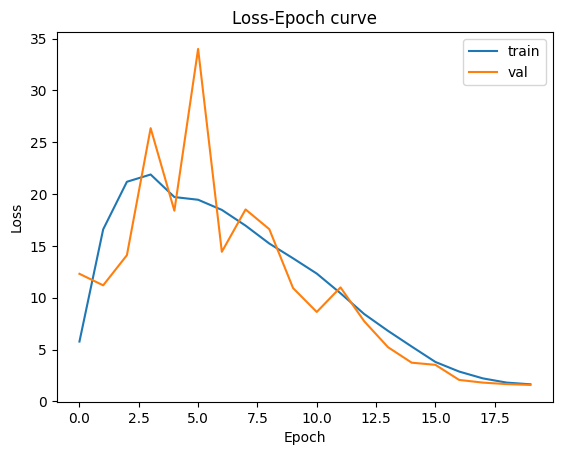

In [49]:

plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('Loss-Epoch curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

##### Evaluation

In [50]:
pre_trained_model = BERTClassifier(bertmodel, num_classes=num_classes, dr_rate=0.4).to(device)
pre_trained_model.load_state_dict(torch.load('KoBERT_best.pt'))


<All keys matched successfully>

In [51]:
model.eval()
val_acc = 0.0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length = valid_length
  label = label.long().to(device)
  out = model(token_ids, valid_length, segment_ids)
  val_acc += calc_accuracy(out, label)
tot_acc = val_acc / (batch_id+1)
print(f"Test acc {tot_acc}")


  0%|          | 0/729 [00:00<?, ?it/s]

Test acc 0.2975455614344503
